This section builds off of the following resources:
https://www.youtube.com/watch?v=984Jz2QCvng
Instructions https://github.com/qupath/i2k-qupath-for-python-programmers
https://qupath.github.io/qubalab-docs/

Create an environment and install qubalab into it with
conda create -n yourEnvironmentName python=3.10

pip install ipython leidenalg igraph umap-learn


## Start QuPath, open your project and an image, and open a connection that you will then use in the next cell
The .gif shows both opening a connection, and seeing that the Python symbol is red, and closing the connection.<br>
Do not close the connection unless you are done!<br>
<img src= "Images/ps_startconnection.gif" width = "800"><br>


In [1]:
from qubalab.qupath import qupath_gateway
from qubalab.images.qupath_server import QuPathServer

gateway = qupath_gateway.create_gateway(auth_token=None, port=25333)
qupath_server = QuPathServer(gateway) # read pixels from qupath via gateway

I used the following script to create cells, feel free to follow along if you have access to the sample data.

setImageType('FLUORESCENCE');
createFullImageAnnotation(true)
qupath.ext.instanseg.core.InstanSeg.builder()
    .modelPath("F:/Scripts/fluorescence_nuclei_and_cells")
    .device("cpu")
    .inputChannels([ColorTransforms.createChannelExtractor("Hoechst"), ColorTransforms.createChannelExtractor("CD31"), ColorTransforms.createChannelExtractor("CD11c"), ColorTransforms.createChannelExtractor("CD68"), ColorTransforms.createChannelExtractor("CD163"), ColorTransforms.createChannelExtractor("CD20"), ColorTransforms.createChannelExtractor("CD4"), ColorTransforms.createChannelExtractor("CD8a"), ColorTransforms.createChannelExtractor("CD45RO"), ColorTransforms.createChannelExtractor("PDL1"), ColorTransforms.createChannelExtractor("LAG3"), ColorTransforms.createChannelExtractor("PD1"), ColorTransforms.createChannelExtractor("CD45"), ColorTransforms.createChannelExtractor("S100a")])
    .outputChannels()
    .tileDims(512)
    .interTilePadding(32)
    .nThreads(12)
    .makeMeasurements(true)
    .randomColors(false)
    .build()
    .detectObjects()
clearSelectedObjects(true);


## Data cleaning
Possibly run some filtering on the cells, to remove outliers or objects we do not think fit our analysis.

In [ ]:
toRemove = []
//Cycle through all of the detected objects, and check for any that do not have a nucleus
//There are a variety of ways of doing this, but one is checking for NaNs in measurements for nuclei.
for (cell in getDetectionObjects()){
    if (cell.measurements.get("Nucleus: Solidity").isNaN()){
        toRemove.add(cell)
    }else if (cell.measurements.get("Nucleus: Area µm^2") ==cell.measurements.get("Cell: Area µm^2")){
        //Additionally, remove any cells that have the exact same area of nucleus and cytoplasm.
        //This is mostly a demonstration of another way to remove certain kinds of detected outliers.
        toRemove.add(cell)
    }
}
print "Objects removed: " + toRemove.size()
removeObjects(toRemove, true)

Additionally, the UMAP function run below throws an error if ANY value is NaN. Since we are cycling through all of the "mean" values, let's go ahead and remove all cells with a mean NaN value.

In [ ]:
toRemove = []

// Iterate over all objects
for (def pathObject in getAllObjects()) {
    // Check if any measurement contains "Mean" and has a NaN value
    if (pathObject.measurements.any { key, value -> key.contains("Mean") && Double.isNaN(value) }) {
        toRemove.add(pathObject)
    }
}

// Remove the collected objects
removeObjects(toRemove, true)

In [ ]:
Check the state of QuPath by taking a snapshot of the interface

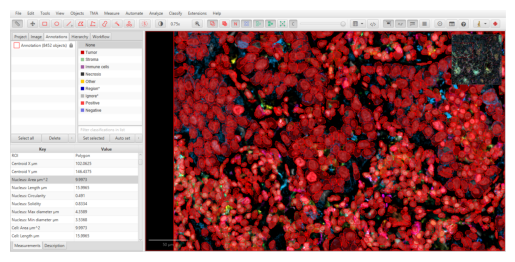

In [2]:
import matplotlib.pyplot as plt

plt.imshow(qupath_gateway.create_snapshot())
plt.axis(False)
plt.show()

Generate a basic dataframe using pandas, and normalize it - something important to keep in mind when performing clustering as different channels in a multiplex image can have vastly different values, yet represent the same amount of protein or have similar impacts on classification.

In [8]:
import pandas as pd
names = detections[0].getMeasurementList().getNames()
names = [x for x in names if x.endswith("Mean")]

detections = gateway.getDetectionObjects()
df = pd.DataFrame(columns = names)
for det in detections:
    df = df._append(
        {name: det.getMeasurements().get(name) for name in names},
        ignore_index=True)

# standardise the columns to avoid scale and shift effects
normalized_df = (df - df.mean()) / df.std()

C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_804\3830618156.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(


Running UMAP
https://umap-learn.readthedocs.io/en/latest/
We could now run a dimensionality reduction algorithm, which might help us to visualise classifiers or other analyses in QuPath.

We can also add these features back into QuPath.

In [9]:
import umap

# run a dimensionality reduction algorithm on the measurements
embedding = umap.UMAP().fit_transform(normalized_df)

# assign back to measurement list
for i in range(embedding.shape[0]):
    detections[i].getMeasurementList().put("UMAP1", float(embedding[i][0]))
    detections[i].getMeasurementList().put("UMAP2", float(embedding[i][1]))

F:\miniconda\envs\qubalab\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
Preparing to cluster cells
We can identify the KNN graph of the cells, and turn this into an adjacency matrix.

In [10]:
from sklearn.neighbors import kneighbors_graph
import igraph

# find KNN graph
A = kneighbors_graph(normalized_df, 50)

# convert matrix to adjacency graph
g = igraph.Graph.Adjacency((A > 0))

In [ ]:
Running clustering
Then, we can cluster the adjacency. We could also have done K-means or something similar.

In [11]:
import leidenalg

# partition the KNN graph based on graph modularity
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

# assign the partitions as classes to the original QuPath objects
for i in range(embedding.shape[0]):
    detections[i].setClassification(f"Cluster {partition.membership[i]}")

In [ ]:
Collect information about clusters